# THEMIS Aurora Image Machine Learning Dataset
In this notebook we demonstrate the process for interacting with a sample of the THEMIS All-Sky Imager Array data set. This data set was developed as part of the NASA Frontier Development Laboratory 2019 Living With Our Star: Enhanced Predictability of GNSS Disturbances Challenge. 

*Kara D. Lamb and the 2019 FDL GNSS Team*

## Introduction

High energy particles from solar activity travel along the Earth's magnetic field, interacting with the Earth's atmosphere in the higher latitudes. These interactions can manifest as a form of visible light in the Earth's ionosphere known as the aurora. 


## THEMIS Ground-based All-Sky Imager (ASI) Array 
The THEMIS (Time History of Events and Macroscale Interactions during Substorms) All-Sky Imager Array is a ground-based observation network to monitor the occurrence of auroral substorms over North America. There are currently 20 sites located across Canada and Alaska, providing continuous images of the aurora at a rate of every 3 seconds. Additional information about the the THEMIS All-Sky Imager network is available here <a href ="https://www.nasa.gov/mission_pages/themis/spacecraft/asi.html" target="_blank">this link</a>

<img src = "assets/THEMISsites.jpg" alt="Drawing" style="width: 800px;"/>

The ASI's capture images of the sky above each camera's location. They use a fish-eye lens (and additional telescoping optics) to project white light images of the sky onto a CCD camera [Mende et al. 2008], capturing the entire sky above each site from horizon to horizon. The intensity of light captured by the ASI is correlated with the observed auroral precipitated energy [Mende et al. 2009], indicating the ASI images can provide meaningful insights into physical processes occuring in the ionosphere, such as localized fluctuations in electron density. 

## Aurora Image ML Dataset
The Aurora Image Data consists of 1 year (2015) of images taken every minute from the Fort Smith and Fort Simpson THEMIS sites. These images are stored in  compressed array format (.npy). The images have been pre-processed to correct for the optical effects of the fish-eyes lens and to project the images to the assumed altitude of the aurora (~110 km), the approximate height of the E region of the ionosphere. Site specific calibration files with azimuth/elevation information for each pixel of the image were used to perform these projections. Pixels at the edge of each image (corresponding to <10 degrees above the horizon) have been removed. 

Previous work that used these data set investigated the connections between high-latitude ionospheric phase scintillations and the presence of the visible aurora:
- <a href ="https://arxiv.org/abs/1910.01570" target="_blank">Prediction of GNSS Phase Scintillations: A Machine Learning Approach</a>
- <a href ="https://arxiv.org/abs/1910.03085" target="_blank">Correlation of Auroral Dynamics and GNSS Scintillation with an Autoencoder</a>

## Who is the Aurora Image ML Dataset for?
This data-set can be used to investigate the dynamics of the aurora, and connections between the visual aurora and other space weather phenomena. It can also be used to test different methods for identifying interesting features in high thoroughput data for improved utilization of all-sky imagers data sets for scientific analysis. 




## 1. Setting up the notebook

In [1]:
%matplotlib inline

import gcsfs
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.animation
import pandas as pd

from IPython.display import HTML
from pathlib import Path

In [2]:
gcs = gcsfs.GCSFileSystem(access="read_only")
loc = "fdl-2019-gnss-themis-dataset/FSMI/2015/"
store = gcsfs.GCSMap(loc, gcs=gcs, check=False)

## 2. Reading and loading the data
The dataset is stored in .npy format. Fort Smith (FSMI) and Fort Simpson (FSIM) are each saved in separate directories. Within each site directory, every month of data is stored in a subdirectory ("01" - "12"), and each day is stored within its month subdirectory as separate subdirectories. The file names give the year, month, day, hour, and minute at which the image data was recorded. 

In [8]:
# projected
imgpathtemp = '{:02d}/{:02d}/'  # month,day
imgfiletemp = 'projected{}-{:02d}-{:02d}T{:02d}:{:02d}:00.000000000.npy'  # year,month, day, hour, minute

Let's list the first 5 images available for FSMI on January 20, 2015:

In [9]:
january20 = os.path.join(loc,imgpathtemp.format(1,20))
gcs.ls(january20)[0:5]

['fdl-2019-gnss-themis-dataset/FSMI/2015/01/20/projected2015-01-20T04:27:00.000000000.npy',
 'fdl-2019-gnss-themis-dataset/FSMI/2015/01/20/projected2015-01-20T04:28:00.000000000.npy',
 'fdl-2019-gnss-themis-dataset/FSMI/2015/01/20/projected2015-01-20T04:29:00.000000000.npy',
 'fdl-2019-gnss-themis-dataset/FSMI/2015/01/20/projected2015-01-20T04:30:00.000000000.npy',
 'fdl-2019-gnss-themis-dataset/FSMI/2015/01/20/projected2015-01-20T04:31:00.000000000.npy']

### 2a. Loading a single image by day and time

In [10]:
# Load a file
year = 2015
month = 2
day = 25
hour = 8
minute = 6
examplefile = os.path.join(loc,imgpathtemp.format(month,day),imgfiletemp.format(year,month,day,hour,minute))
print(examplefile)

with gcs.open(examplefile, 'rb') as f:
    imgarray = np.load(f)

fdl-2019-gnss-themis-dataset/FSMI/2015/02/25/projected2015-02-25T08:06:00.000000000.npy


(256, 256)

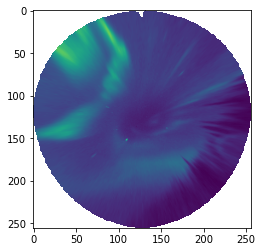

In [11]:
plt.imshow(imgarray)
imgarray.shape

### 2b. Visualize the available image files 
We can use the GCSFS.find function to list all available image files for the FSMI site.

In [12]:
fsmi2015 = gcs.find(os.path.join(loc))
print(len(fsmi2015))

86655


We can use the re.match function to get the datestamps from the image file names

In [9]:
filepathtmp = 'fdl-2019-gnss-themis-dataset/FSMI/2015/(.*)/(.*)/projected(.*).000000000.npy'
timestamps = []
filepaths = []

for imgfile in fsmi2015:
    m = re.match(filepathtmp, imgfile)
    timestamps.append(m[3])
    filepaths.append(imgfile)

The time stamps are in the format year-month-day-hour-minute-second, e.g. '2015-01-11T04:27:00'. The data set is at a frequency of every 1 minute, but the image data is only available for a specified time each night and when the ASI are fully operational. To get an overview of the data coverage for the entire year, we can use pandas to fill in the time stamps for the entire year at a frequency of 1 minute.

We'll first create a dataframe with columns for the timestamps and filepaths, with the timestamp set to be a panda DatatimeIndex.

In [10]:
df_time = pd.DataFrame(list(zip(timestamps,filepaths)), index=np.arange(len(timestamps)), columns=["Time","Filepaths"])
df_time["Time"] = pd.to_datetime(df_time["Time"])
df_time.index = pd.DatetimeIndex(df_time['Time'])

To fill in the the timestamps for the entire year, we'll create a DatetimeIndex for the entire year at 1 minute frequency and reindex the dataframe to this new index, with NaN's for the times where no images are available

In [11]:
idx = pd.date_range('2015-01-01T00:00:00', '2016-01-01T00:00:00',freq='T')
df_time = df_time.reindex(idx,fill_value='NaN')

Now we can count how many image files are available at each hour for every day of the year by using pandas' groupby function

In [12]:
days = pd.unique(df_time.index.dayofyear)
ndays = len(pd.unique(days))
availdata = np.zeros((24,ndays))
i = 0
for day in days:
    df = df_time[df_time.index.dayofyear==day]["Time"]
    availdata[:,i]=np.ndarray.flatten(df.groupby(df.index.hour).agg('count').values)
    i = i+1

Since this site is located near the Arctic circle, the data availability is greater for the winter months, when there are more nighttime hours.

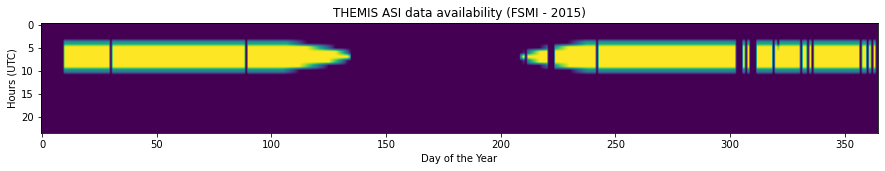

In [13]:
plt.figure(figsize=(15,20))
plt.imshow(availdata,aspect=2)
plt.title("THEMIS ASI data availability (FSMI - 2015)")
plt.ylabel("Hours (UTC)")
plt.xlabel("Day of the Year")
plt.show()

## 3. Visualize the ASI data  for 1 day
Let's visualize the ASI data for one day of the year. We'll choose data at a frequency of every 10 minutes.

In [14]:
df_day = df_time[df_time.index.dayofyear==49]
df_day = df_day.resample('10min').first()
df_day = df_day.dropna(axis='rows',how='any')

Load the image files into a numpy array that is 36 x 256 x 256. 

In [15]:
data = np.zeros((len(df_day)-1,256, 256))

for jj in range(1,data.shape[0]):
    file = df_day["Filepaths"][jj]
    with gcs.open(file, 'rb') as f:
        imag = np.load(f)
        data[jj,:,:]=imag

Now we can create an animation from the images to view a 6 hour time-lapse of the aurora. First we will create a new figure for the animation.

In [16]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100 
plt.ioff()

fig = plt.figure();

<Figure size 600x400 with 0 Axes>

Then we can loop through the data in the numpy array to create the time-lapse.

In [17]:
ax = fig.add_subplot(111)
def animate(t):
    ax.cla();
    ax.imshow(data[t,:,:]);
    
matplotlib.animation.FuncAnimation(fig,animate,frames=data.shape[0])